In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
#Load config 
import yaml
with open('./config.yml', 'r', encoding='utf-8') as f:
    CONFIG = yaml.load(f, yaml.FullLoader)

In [3]:
from data import imdb, IMBDWrapped, get_prerpocessor
from torch.utils.data import random_split, Dataset, DataLoader
from model import get_model
from losses import get_loss
from optimizer import get_optimizer
import torch
def wrap_ds(ds: Dataset, shuffle=False) -> DataLoader:
    """Create data loader"""
    processors = get_prerpocessor(CONFIG['data']['preprocess'])
    wrapped_ds = IMBDWrapped(ds, processors)
    return DataLoader(wrapped_ds, batch_size=CONFIG['data']['batch_size'], shuffle=shuffle)

def init_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f'Init device: {device}')
    CONFIG['training']['device'] = device

def init_data():
    """Read dataset and setup data loaders"""
    print(f'Loading data: {CONFIG["data"]}')
    data = imdb()
    train_ds, test_ds = data['train'], data['test']
    train_ds, val_ds = random_split(train_ds, CONFIG['data']['split'])
    train_loader, val_loader, test_loader = wrap_ds(train_ds, True), wrap_ds(val_ds, True), wrap_ds(test_ds, True)
    CONFIG['training']['train_loader'] = train_loader
    CONFIG['training']['validation_loader'] = val_loader
    CONFIG['test']['ds_loader'] = test_loader
    
def init_model():
    print(f'Init model: {CONFIG["architechture"]}')
    model = get_model(**CONFIG['architechture'])
    model = model.to(CONFIG['training']['device'])
    CONFIG['training']['model'] = model
    
def init_loss():
    print(f'Init loss function: {CONFIG["loss"]}')
    CONFIG['training']['criteria'] = get_loss(**CONFIG['loss']).to(CONFIG['training']['device'])

def init_optimizer():
    print(f'Init optimizer: {CONFIG["optimizer"]}')
    optimizer = get_optimizer(
        CONFIG['training']['model'].parameters(),
        **CONFIG['optimizer'])
    CONFIG['training']['optimizer'] = optimizer
    
def init():
    init_device()
    init_data()
    init_model()
    init_loss()
    init_optimizer()
    
init()
    

Init device: cuda
Loading data: {'preprocess': ['simple_preprocess'], 'batch_size': 64, 'split': [0.8, 0.2]}
Init model: {'name': 'FacebookAI/roberta-base', 'tokenizer': {'max_length': 300}, 'classifier': {'num_labels': 2, 'hidden_dims': [256], 'dropout': 0.0}}


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Init loss function: {'name': 'CrossEntropyLoss', 'label_smoothing': 0.1}
Init optimizer: {'name': 'Adam', 'lr': 5e-05, 'weight_decay': 0}


In [6]:
# model = get_model(**CONFIG['architechture'])
# model = model.to(CONFIG['training']['device'])
CONFIG['training']['model'].load_checkpoint(CONFIG['training']['save_path'])

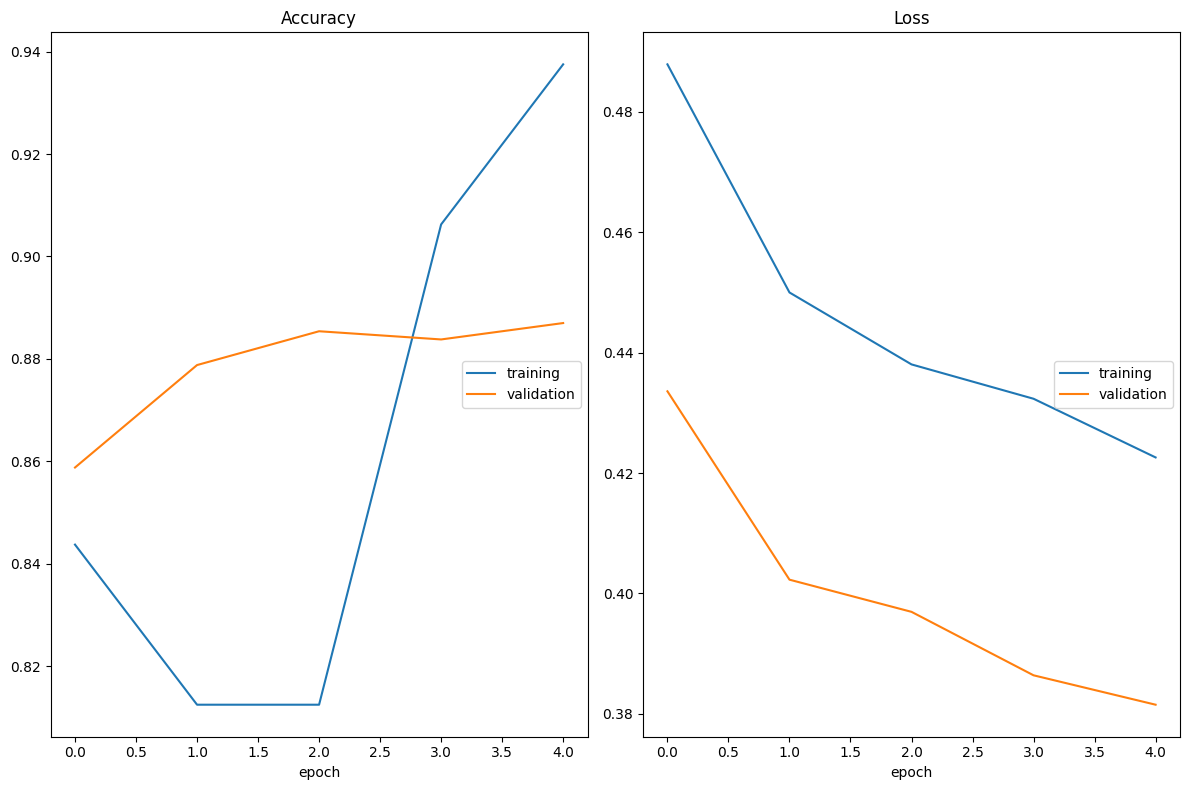

In [7]:
from train import optimize
optimize(**CONFIG['training'], test=False)

In [8]:
from test import test, print_metric

In [9]:
test(CONFIG['training']['model'], metric_callbacks=[print_metric], verbose=True, **CONFIG['test'])

Start testing model, batch_size=64, number of batch 391
Evaluted batch 0
Accuracy: 0.921875
Evaluted batch 1
Accuracy: 0.90625
Evaluted batch 2
Accuracy: 0.890625
Evaluted batch 3
Accuracy: 0.87109375
Evaluted batch 4
Accuracy: 0.875
Evaluted batch 5
Accuracy: 0.8723958134651184
Evaluted batch 6
Accuracy: 0.8660714030265808
Evaluted batch 7
Accuracy: 0.873046875
Evaluted batch 8
Accuracy: 0.8715277910232544
Evaluted batch 9
Accuracy: 0.8656250238418579
Evaluted batch 10
Accuracy: 0.8678977489471436
Evaluted batch 11
Accuracy: 0.859375
Evaluted batch 12
Accuracy: 0.8605769276618958
Evaluted batch 13
Accuracy: 0.8604910969734192
Evaluted batch 14
Accuracy: 0.862500011920929
Evaluted batch 15
Accuracy: 0.865234375
Evaluted batch 16
Accuracy: 0.8648896813392639
Evaluted batch 17
Accuracy: 0.8663194179534912
Evaluted batch 18
Accuracy: 0.8667762875556946
Evaluted batch 19
Accuracy: 0.8656250238418579
Evaluted batch 20
Accuracy: 0.866815447807312
Evaluted batch 21
Accuracy: 0.869318187236785

{'Accuracy': 0.8841999769210815}

In [ ]:
#Run after flask run
import requests
res = requests.post("http://localhost:5000/predict", json={'text':'Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a crappy copy of the VHS cannot be redeemed by consuming liquor. Trust me, because I stuck this turkey out to the end. It was so pathetically bad all over that I had to figure it was a fourth-rate spoof of Springtime for Hitler.<br /><br />The girl who played Janis Joplin was the only faint spark of interest, and that was only because she could sing better than the original.<br /><br />If you want to watch something similar but a thousand times better, then watch Beyond The Valley of The Dolls.'})
res.json()

{'confidence': 0.5205522775650024, 'label': 'negative'}